In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import shutil
import random
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.preprocessing import label_binarize

In [ ]:
original_dataset_dir = '/content/drive/My Drive/datasett'

In [ ]:
base_dir = '/content/drive/My Drive/split_dataset'
os.makedirs(base_dir, exist_ok=True)

# Buat direktori untuk train, validation, dan test
for split in ['train', 'validation', 'test']:
    os.makedirs(os.path.join(base_dir, split, 'rock'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, 'paper'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, 'scissors'), exist_ok=True)

In [ ]:
# Fungsi untuk membagi dataset
def split_data(class_name):
    class_dir = os.path.join(original_dataset_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)  # Acak gambar

    total_images = len(images)
    n_train = int(total_images * 0.8)   # 80% untuk training
    n_val = int(total_images * 0.1)     # 10% untuk validation
    n_test = total_images - n_train - n_val  # Sisa gambar untuk test (10%)

    # Pindahkan gambar ke folder masing-masing
    for i in range(n_train):
        shutil.copy(os.path.join(class_dir, images[i]), os.path.join(base_dir, 'train', class_name))
    for i in range(n_train, n_train + n_val):
        shutil.copy(os.path.join(class_dir, images[i]), os.path.join(base_dir, 'validation', class_name))
    for i in range(n_train + n_val, total_images):
        shutil.copy(os.path.join(class_dir, images[i]), os.path.join(base_dir, 'test', class_name))

# Panggil fungsi untuk setiap kelas
classes = ['rock', 'paper', 'scissors']
for cls in classes:
    split_data(cls)

print("Pembagian dataset selesai!")

# Cek jumlah gambar di masing-masing folder
for cls in classes:
    train_count = len(os.listdir(os.path.join(base_dir, 'train', cls)))
    val_count = len(os.listdir(os.path.join(base_dir, 'validation', cls)))
    test_count = len(os.listdir(os.path.join(base_dir, 'test', cls)))

    print(f"Kelas: {cls}")
    print(f"Training: {train_count}, Validation: {val_count}, Test: {test_count}")


Pembagian dataset selesai!
Kelas: rock
Training: 726, Validation: 488, Test: 493
Kelas: paper
Training: 712, Validation: 474, Test: 458
Kelas: scissors
Training: 750, Validation: 394, Test: 412


In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

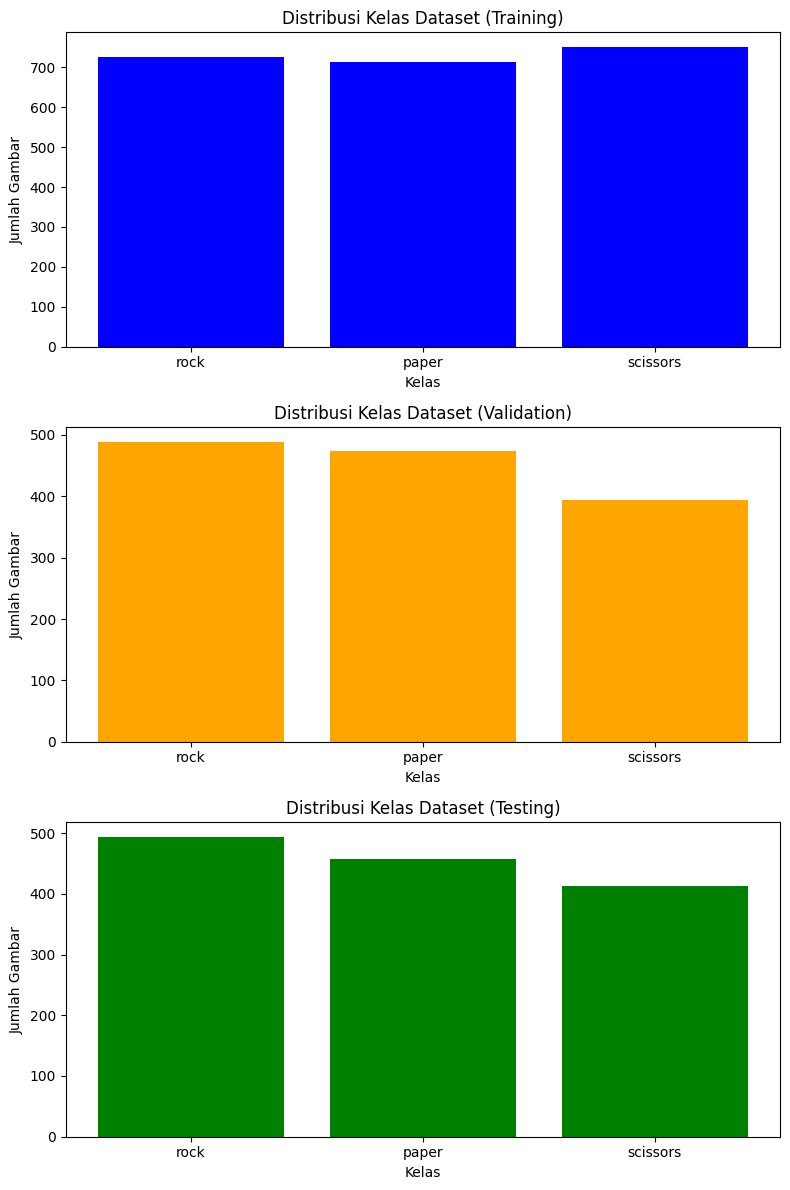

In [ ]:
# Daftar kelas
classes = ['rock', 'paper', 'scissors']
class_counts_train = {}
class_counts_validation = {}
class_counts_test = {}

# Hitung jumlah gambar di masing-masing kelas untuk train, validation, dan test
for cls in classes:
    class_counts_train[cls] = len(os.listdir(os.path.join(train_dir, cls)))
    class_counts_validation[cls] = len(os.listdir(os.path.join(validation_dir, cls)))
    class_counts_test[cls] = len(os.listdir(os.path.join(test_dir, cls)))

# Visualisasi distribusi kelas untuk training, validation, dan testing
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

# Plot untuk training
ax[0].bar(class_counts_train.keys(), class_counts_train.values(), color='blue')
ax[0].set_title('Distribusi Kelas Dataset (Training)')
ax[0].set_xlabel('Kelas')
ax[0].set_ylabel('Jumlah Gambar')

# Plot untuk validation
ax[1].bar(class_counts_validation.keys(), class_counts_validation.values(), color='orange')
ax[1].set_title('Distribusi Kelas Dataset (Validation)')
ax[1].set_xlabel('Kelas')
ax[1].set_ylabel('Jumlah Gambar')

# Plot untuk testing
ax[2].bar(class_counts_test.keys(), class_counts_test.values(), color='green')
ax[2].set_title('Distribusi Kelas Dataset (Testing)')
ax[2].set_xlabel('Kelas')
ax[2].set_ylabel('Jumlah Gambar')

plt.tight_layout()
plt.show()

# Menampilkan jumlah total data
total_train = sum(class_counts_train.values())
total_validation = sum(class_counts_validation.values())
total_test = sum(class_counts_test.values())

print(f"Total Data Training: {total_train}")
print(f"Total Data Validation: {total_validation}")
print(f"Total Data Testing: {total_test}")

In [ ]:
# Alexnet

# Inisialisasi ImageDataGenerator untuk pelatihan dengan pembagian validasi
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalisasi
    validation_split=0.1  # Pembagian 10% untuk validasi
)

# Membuat generator untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Menggunakan subset training
)

# Membuat generator untuk validation
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Menggunakan subset validation
)

print(f"Total data training: {train_generator.samples}")
print(f"Total data validation: {validation_generator.samples}")

Total Data Training: 2188
Total Data Validation: 1356
Total Data Testing: 1363
Found 1970 images belonging to 3 classes.
Found 218 images belonging to 3 classes.
Total data training: 1970
Total data validation: 218


In [ ]:
# VGG

# Inisialisasi ImageDataGenerator untuk pelatihan dengan pembagian validasi
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalisasi
    validation_split=0.1  # Pembagian 10% untuk validasi
)

# Membuat generator untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Menggunakan subset training
)

# Membuat generator untuk validation
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Menggunakan subset validation
)

print(f"Total data training: {train_generator.samples}")
print(f"Total data validation: {validation_generator.samples}")

In [ ]:
# Kelas dasar untuk model
class BaseModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

In [ ]:
class AlexNet(BaseModel):
  def build_model(self):
    model = models.Sequential()

    #1st Conv Layer
    model.add(layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=self.input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3, 3), strides=2))

    #2nd Conv Layer
    model.add(layers.Conv2D(256, (5, 5), padding='same', activation=  'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3, 3), strides=2))

    #3rd Conv Layer
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    #4th Conv Layer
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    #5th Conv Layer
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))

    #Flattening
    model.add(layers.Flatten())

    #Fully Connected Layers
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(self.num_classes, activation='softmax'))

    return model

In [ ]:
class VGG16(BaseModel):
  def build_model(self):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=self.input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    # Flattening
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(self.num_classes, activation='softmax'))

    return model

In [ ]:
# Inisialisasi dan kompilasi model
alexnet_model = AlexNet(input_shape=(227, 227, 3), num_classes=3).build_model()
alexnet_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
vgg16_model = VGG16(input_shape=(224, 224, 3), num_classes=3).build_model()
vgg16_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

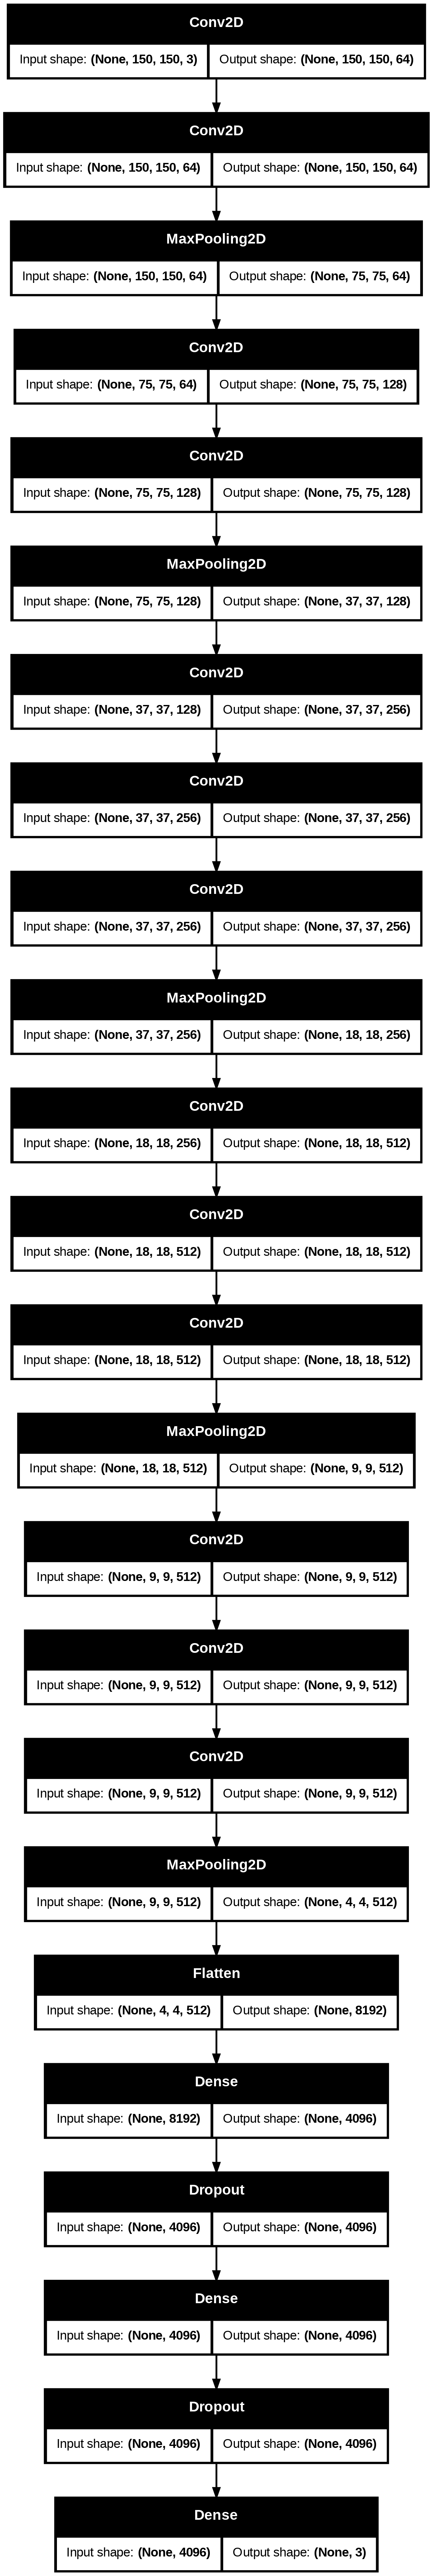

In [ ]:
# Visualisasi AlexNet
plot_model(alexnet_model, to_file='alexnet_model.png', show_shapes=True)

# Visualisasi VGG16
plot_model(vgg16_model, to_file='vgg16_model.png', show_shapes=True)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    patience=5,
    verbose=1,
    mode='max',
    baseline=0.97
)

In [ ]:
# Train AlexNet
history_alexnet = alexnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.6098 - loss: 2.7776 - val_accuracy: 0.5917 - val_loss: 0.9906
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 0.9723 - loss: 0.0979 - val_accuracy: 0.4174 - val_loss: 1.2699
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.9768 - loss: 0.0907 - val_accuracy: 0.5413 - val_loss: 2.6168
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.9808 - loss: 0.0777 - val_accuracy: 0.9862 - val_loss: 0.0593
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - accuracy: 0.9861 - loss: 0.0723 - val_accuracy: 0.8119 - val_loss: 0.5546
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.9868 - loss: 0.0430 - val_accuracy: 0.9817 - val_loss: 0.1047
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.9801 - loss: 0.0916 - val_accuracy: 0.9587 - val_loss: 0.1205
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.9776 - loss: 0.1094 - val_accuracy: 0.9450 

In [ ]:
# Train VGG16
history_vgg16 = vgg16_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 84s 868ms/step - accuracy: 0.3235 - loss: 1.1034 - val_accuracy: 0.3303 - val_loss: 1.1017
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.3287 - loss: 1.1019 - val_accuracy: 0.3303 - val_loss: 1.0987
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.3332 - loss: 1.0994 - val_accuracy: 0.3440 - val_loss: 1.0984
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - accuracy: 0.3365 - loss: 1.0993 - val_accuracy: 0.3440 - val_loss: 1.0984
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 277ms/step - accuracy: 0.3227 - loss: 1.1000 - val_accuracy: 0.3440 - val_loss: 1.0988
Epoch 5: early stopping


In [ ]:
# Evaluasi model pada data test Alexnet
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1363 images belonging to 3 classes.


In [ ]:
# Evaluasi model pada data test VGG
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
test_loss_alexnet, test_acc_alexnet = alexnet_model.evaluate(test_generator, verbose=2)

43/43 - 263s - 6s/step - accuracy: 0.8892 - loss: 0.4862


In [ ]:
test_loss_vgg16, test_acc_vgg16 = vgg16_model.evaluate(test_generator, verbose=2)

43/43 - 14s - 316ms/step - accuracy: 0.3023 - loss: 1.1031


In [ ]:
print('\nTest accuracy (AlexNet):', test_acc_alexnet)
print('Test accuracy (VGG16):', test_acc_vgg16)


Test accuracy (AlexNet): 0.8892149925231934
Test accuracy (VGG16): 0.3022744059562683


In [ ]:
# Prediksi
y_pred_alexnet = alexnet_model.predict(test_generator)
y_pred_classes_alexnet = np.argmax(y_pred_alexnet, axis=1)

y_pred_vgg16 = vgg16_model.predict(test_generator)
y_pred_classes_vgg16 = np.argmax(y_pred_vgg16, axis=1)

# Laporan klasifikasi
print('Classification Report (AlexNet)')
print(classification_report(test_generator.classes, y_pred_classes_alexnet, target_names=classes))

print('Classification Report (VGG16)')
print(classification_report(test_generator.classes, y_pred_classes_vgg16, target_names=classes))


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step
Classification Report (AlexNet)
              precision    recall  f1-score   support

        rock       0.98      0.81      0.89       458
       paper       0.99      0.87      0.93       493
    scissors       0.75      1.00      0.85       412

    accuracy                           0.89      1363
   macro avg       0.91      0.89      0.89      1363
weighted avg       0.91      0.89      0.89      1363

Classification Report (VGG16)
              precision    recall  f1-score   support

        rock       0.00      0.00      0.00       458
       paper       0.00      0.00      0.00       493
    scissors       0.30      1.00      0.46       412

    accuracy                           0.30      1363
   macro avg       0.10      0.33      0.15      1363
weighted avg       0.09      0.30      0.14      1363



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


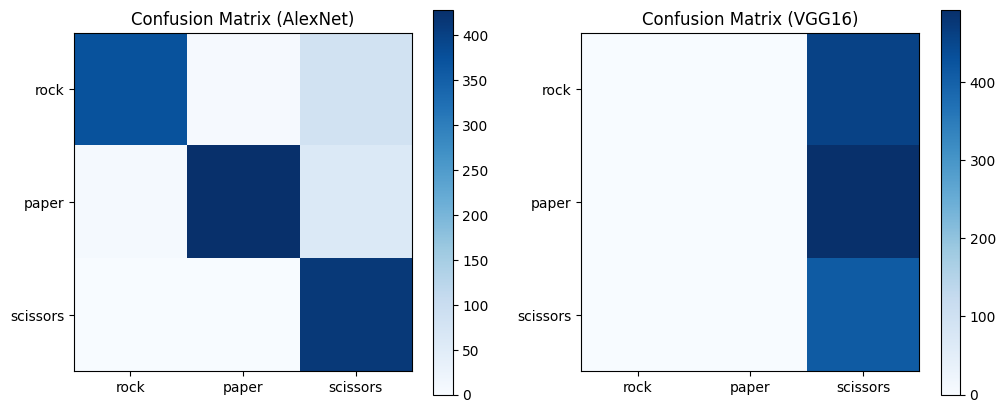

In [ ]:
# Confusion Matrix
conf_matrix_alexnet = confusion_matrix(test_generator.classes, y_pred_classes_alexnet)
conf_matrix_vgg16 = confusion_matrix(test_generator.classes, y_pred_classes_vgg16)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Confusion Matrix (AlexNet)')
plt.imshow(conf_matrix_alexnet, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.subplot(1, 2, 2)
plt.title('Confusion Matrix (VGG16)')
plt.imshow(conf_matrix_vgg16, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.show()

In [ ]:
# Hitung ROC-AUC

# Menghitung AUC untuk AlexNet
roc_auc_alexnet = roc_auc_score(y_true, y_pred_alexnet, multi_class='ovr')
# Menghitung AUC untuk VGG16
roc_auc_vgg16 = roc_auc_score(y_true, y_pred_vgg16, multi_class='ovr')

print('ROC AUC Score (AlexNet):', roc_auc_alexnet)
print('ROC AUC Score (VGG16):', roc_auc_vgg16)

ROC AUC Score (AlexNet): 0.9482312761039879
ROC AUC Score (VGG16): 0.5


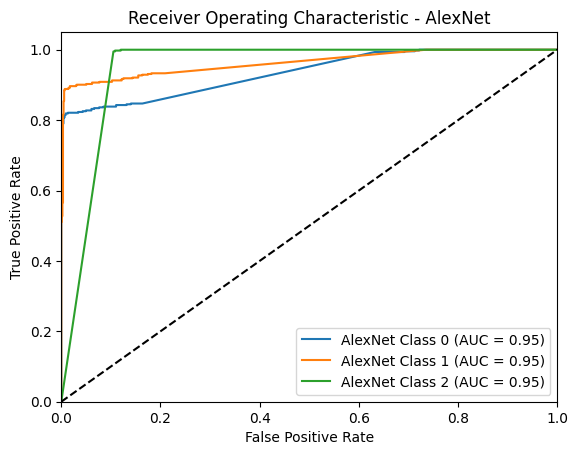

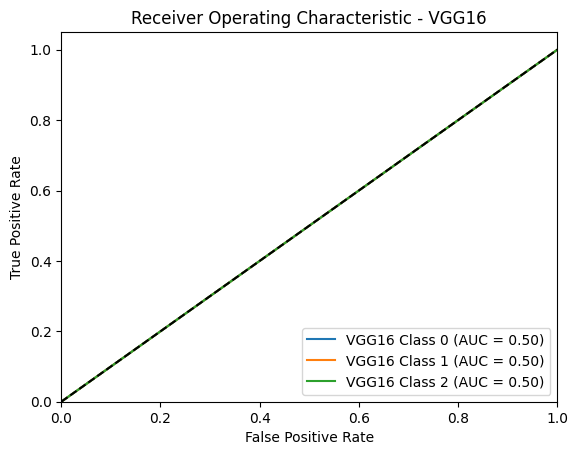

In [ ]:
# Visualisasi ROC Curve untuk AlexNet
plt.figure()
for i in range(n_classes):
    plt.plot(fpr_alexnet[i], tpr_alexnet[i], label='AlexNet Class {} (AUC = {:.2f})'.format(i, roc_auc_alexnet))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - AlexNet')
plt.legend(loc='lower right')
plt.show()

# Visualisasi ROC Curve untuk VGG16
plt.figure()
for i in range(n_classes):
    plt.plot(fpr_vgg16[i], tpr_vgg16[i], label='VGG16 Class {} (AUC = {:.2f})'.format(i, roc_auc_vgg16))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - VGG16')
plt.legend(loc='lower right')
plt.show()


Kesimpulan:

AlexNet adalah model yang jauh lebih baik dalam menangani dataset Rock, Paper, Scissors. Ia memberikan akurasi tinggi, loss rendah, dan performa yang stabil di semua metrik evaluasi.

VGG16 memiliki performa yang sangat buruk dan gagal melakukan klasifikasi dengan baik, sehingga kurang cocok untuk dataset ini.

Untuk dataset yang lebih sederhana seperti Rock, Paper, Scissors, AlexNet yang lebih ringan lebih efektif dibandingkan VGG16 yang lebih berat dan kompleks.